In [1]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchinfo import summary
from sklearn.metrics import roc_curve, auc, confusion_matrix

# from models.cvt import CvT, EqCvT
from typing import *
from utils.util import (
    make_directories,
    seed_everything,
    get_device,
    init_logging_handler,
)
from utils.dataset import download_dataset, DeepLenseDataset, visualize_samples
from utils.train import train
from utils.inference import Inference
from argparse import ArgumentParser
from config.data_config import DATASET
from config.eqcvt_config import EQCVT_CONFIG
from config.pretrained_config import PRETRAINED_CONFIG
from utils.augmentation import get_transform_test, get_transform_train
from torch.utils.data import DataLoader
import timm
from torchvision import models
from models.cnn_zoo import Model, ConViT
import math
from transformers import get_cosine_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, random_split
from models.transformer_zoo import (
    GetCrossFormer,
    GetTwinsSVT,
    GetLeViT,
    GetPiT,
    GetCCT,
    GetT2TViT,
    TransformerModels,
)

from config.cct_config import CCT_CONFIG
from config.twinssvt_config import TWINSSVT_CONFIG
from config.levit_config import LEVIT_CONFIG
from config.cait_config import CAIT_CONFIG
from config.crossvit_config import CROSSVIT_CONFIG
from config.pit_config import PIT_CONFIG
import json


In [2]:
# run in the case of Colab only
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

In [3]:
# To view the dataset, ROC curve and confusion matrix:
# Please comment out: matplotlib.use("Agg") from utils/inference.py file

In [4]:
dataset_name = "Model_III"
dataset_dir = "data"
use_cuda = True
num_workers = 10
train_config_name = "TwinsSVT"

classes = DATASET[f"{dataset_name}"]["classes"]

if train_config_name == "CCT":
    train_config = CCT_CONFIG
elif train_config_name == "TwinsSVT":
    train_config = TWINSSVT_CONFIG
elif train_config_name == "LeViT":
    train_config = LEVIT_CONFIG
elif train_config_name == "CaiT":
    train_config = CAIT_CONFIG
elif train_config_name == "CrossViT":
    train_config = CROSSVIT_CONFIG
elif train_config_name == "PiT":
    train_config = PIT_CONFIG
else:
    train_config = CCT_CONFIG  # temporary

In [5]:
network_type = train_config["network_type"]
network_config = train_config["network_config"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]
lr_schedule_config = train_config["lr_schedule_config"]

make_directories([dataset_dir])

In [6]:
trainset = DeepLenseDataset(
    dataset_dir,
    "train",
    dataset_name,
    transform=get_transform_train(
        upsample_size=387,
        final_size=train_config["image_size"],
        channels=train_config["channels"],
    ),
    download=True,
    channels=train_config["channels"],
)

Model_III dataset already exists


In [7]:
split_ratio = 0.25
valid_len = int(split_ratio * len(trainset))
train_len = len(trainset) - valid_len
trainset, testset = random_split(trainset, [train_len, valid_len])

In [8]:
seed_everything(seed=42)
device = get_device(use_cuda=use_cuda, cuda_idx=0)

# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir_base = "logger"
log_dir = f"{log_dir_base}/{current_time}"
init_logging_handler(log_dir_base, current_time)

PATH = os.path.join(
    f"{log_dir}/checkpoint", f"{network_type}_{dataset_name}_{current_time}.pt"
)

Using device = cuda:0


In [9]:
train_loader = DataLoader(
    dataset=trainset,
    batch_size=train_config["batch_size"],
    shuffle=True,
    num_workers=num_workers,
)
test_loader = DataLoader(
    dataset=testset,
    batch_size=train_config["batch_size"],
    shuffle=True,
    num_workers=num_workers,
)

In [10]:
sample = next(iter(train_loader))
print(sample[0].shape)

torch.Size([64, 1, 224, 224])


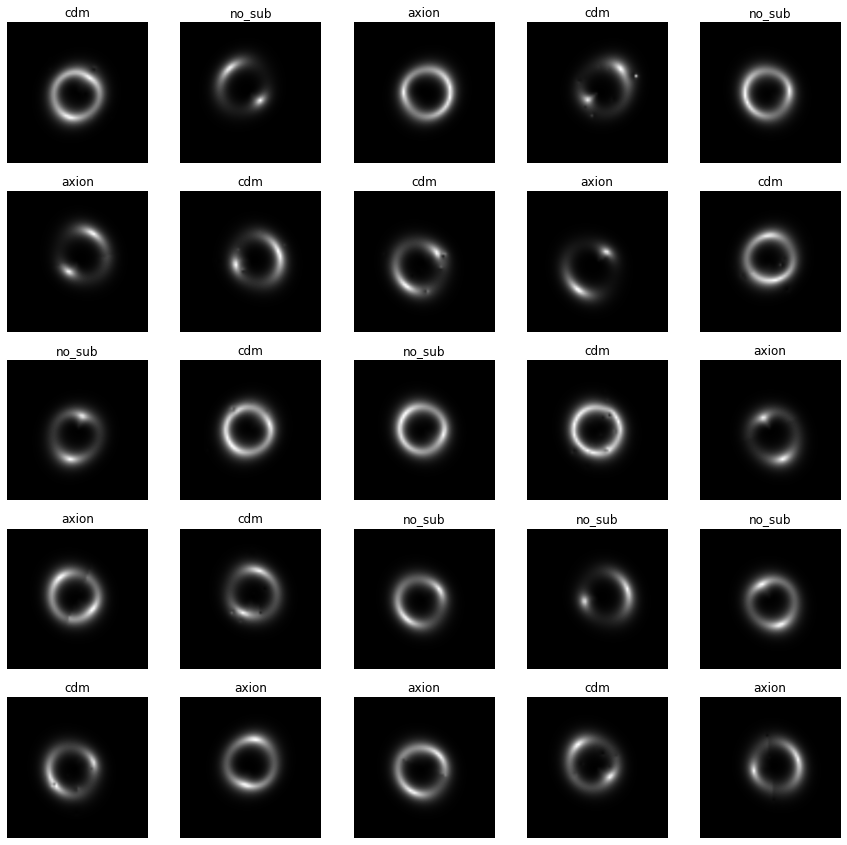

In [11]:
visualize_samples(dataset=trainset, labels_map=classes)

In [ ]:

num_classes = len(classes)  # number of classes to be classified
print(num_classes)
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(testset)}")


In [ ]:
# Transformer model
model = TransformerModels(
    transformer_type=train_config["network_type"],
    num_channels=train_config["channels"],
    num_classes=num_classes,
    img_size=image_size,
    **train_config["network_config"],
)

summary(model, input_size=(train_config["batch_size"], 1, image_size, image_size))

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=optimizer_config["lr"],
    weight_decay=optimizer_config["weight_decay"],
)

epochs = train_config["num_epochs"]
warmup_epochs = optimizer_config["warmup_epoch"]
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps = num_train_steps * warmup_epochs
num_training_steps = int(num_train_steps * epochs)

# learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

In [ ]:
train_config["dataset_name"] = dataset_name
train_config["lr_schedule_config"]["cosine_scheduler"] = {}
train_config["lr_schedule_config"]["cosine_scheduler"][
    "num_warmup_steps"
] = num_warmup_steps
train_config["lr_schedule_config"]["cosine_scheduler"]["num_training_steps"] = int(
    num_training_steps
)

with open(f"{log_dir}/config.json", "w") as fp:
    json.dump(train_config, fp)

In [ ]:
train(
    epochs=epochs,  # train_config["num_epochs"],
    model=model,
    device=device,
    train_loader=train_loader,
    valid_loader=test_loader,  # change to val-loader
    criterion=criterion,
    optimizer=optimizer,
    use_lr_schedule=train_config["lr_schedule_config"]["use_lr_schedule"],
    scheduler_step=cosine_scheduler,
    path=PATH,
    log_freq=20,
    config=train_config,
    dataset_name=dataset_name,
)

In [ ]:
infer_obj = Inference(
    model,
    test_loader,
    device,
    num_classes,
    testset,
    dataset_name,
    labels_map=classes,
    image_size=image_size,
    channels=train_config["channels"],
    destination_dir="data",
    log_dir=log_dir,  # log_dir
)

In [ ]:
infer_obj.infer_plot_roc()

In [ ]:
infer_obj.generate_plot_confusion_matrix()